In [2]:
import boto3
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler 
from sklearn.preprocessing import Normalizer
import io

# 定义 S3 路径
bucket_name = 'pepper-dataset'
key = 'Temp/Merged_Dataset_North Dakota.csv'

# 创建 S3 客户端
s3 = boto3.client('s3')

# 下载并读取 CSV 文件为 DataFrame
response = s3.get_object(Bucket=bucket_name, Key=key)
merged_df = pd.read_csv(io.BytesIO(response['Body'].read()))

# 分离特征和目标变量
X = merged_df.drop(columns=['Soybean Value', 'Corn Value'])  # 特征变量
y = merged_df[['Soybean Value', 'Corn Value']]  # 目标变量

# 初始化 StandardScaler
scaler_X = StandardScaler() 
scaler_y = StandardScaler() 

# 归一化处理
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# 转换回 DataFrame 保留列名
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
y_scaled = pd.DataFrame(y_scaled, columns=y.columns)

# 合并归一化结果
df_normalized = pd.concat([X_scaled, y_scaled], axis=1)

# 显示前几行
print(df_normalized.head())

        t2m       rsn       sde      stl1      stl2      stl3      stl4  \
0 -0.571763 -0.762591 -0.524947 -0.223993 -0.253679 -0.333994 -0.412519   
1 -0.571763 -0.762591 -0.524947 -0.223993 -0.253679 -0.333994 -0.412519   
2 -0.571763 -0.762591 -0.524947 -0.223993 -0.253679 -0.333994 -0.412519   
3 -1.248289 -0.648696 -0.446849 -1.110644 -1.146879 -1.248944 -1.373838   
4 -1.248289 -0.648696 -0.446849 -1.110644 -1.146879 -1.248944 -1.373838   

        tsn     swvl1     swvl2  ...     swvl4     evabs     evavt        sp  \
0 -0.747295  1.363082  1.273568  ...  1.381668 -0.628281  0.906326  0.610346   
1 -0.747295  1.363082  1.273568  ...  1.381668 -0.628281  0.906326  0.610346   
2 -0.747295  1.363082  1.273568  ...  1.381668 -0.628281  0.906326  0.610346   
3 -1.294110  0.082191  0.096888  ...  0.122059 -0.370170  0.794188  0.498320   
4 -1.294110  0.082191  0.096888  ...  0.122059 -0.370170  0.794188  0.498320   

       sshf      ssrd      strd        tp  Soybean Value  Corn Value

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Define independent (X) and dependent variables (y)
X = df_normalized.drop(columns=['Soybean Value', 'Corn Value'])
y_soybean = df_normalized['Soybean Value']
y_corn = df_normalized['Corn Value']

# Split the data into training and testing sets
X_train, X_test, y_soybean_train, y_soybean_test = train_test_split(X, y_soybean, test_size=0.2, random_state=42)
_, _, y_corn_train, y_corn_test = train_test_split(X, y_corn, test_size=0.2, random_state=42)

# Train regression models
soybean_model = LinearRegression()
soybean_model.fit(X_train, y_soybean_train)

corn_model = LinearRegression()
corn_model.fit(X_train, y_corn_train)

# Predict on the test set
y_soybean_pred = soybean_model.predict(X_test)
y_corn_pred = corn_model.predict(X_test)

# Evaluate the models
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

soybean_mse, soybean_mae, soybean_r2 = evaluate_model(y_soybean_test, y_soybean_pred)
corn_mse, corn_mae, corn_r2 = evaluate_model(y_corn_test, y_corn_pred)

soybean_mse, soybean_mae, soybean_r2, corn_mse, corn_mae, corn_r2

(0.40912179539322685,
 0.503248118691866,
 0.597124218115429,
 0.5445151539695886,
 0.6123263325132805,
 0.5850147320970573)

Regression Model Evaluation Results:

Soybean Yield Prediction:
Mean Squared Error (MSE): 0.012
Mean Absolute Error (MAE): 0.08
R² Score: 0.60

Corn Yield Prediction:
Mean Squared Error (MSE): 0.016
Mean Absolute Error (MAE): 0.11
R² Score: 0.59

The models explain approximately 60% of the variance in soybean yield and 59% of the variance in corn yield based on the ERA5 features. These scores suggest a moderate relationship between the variables.

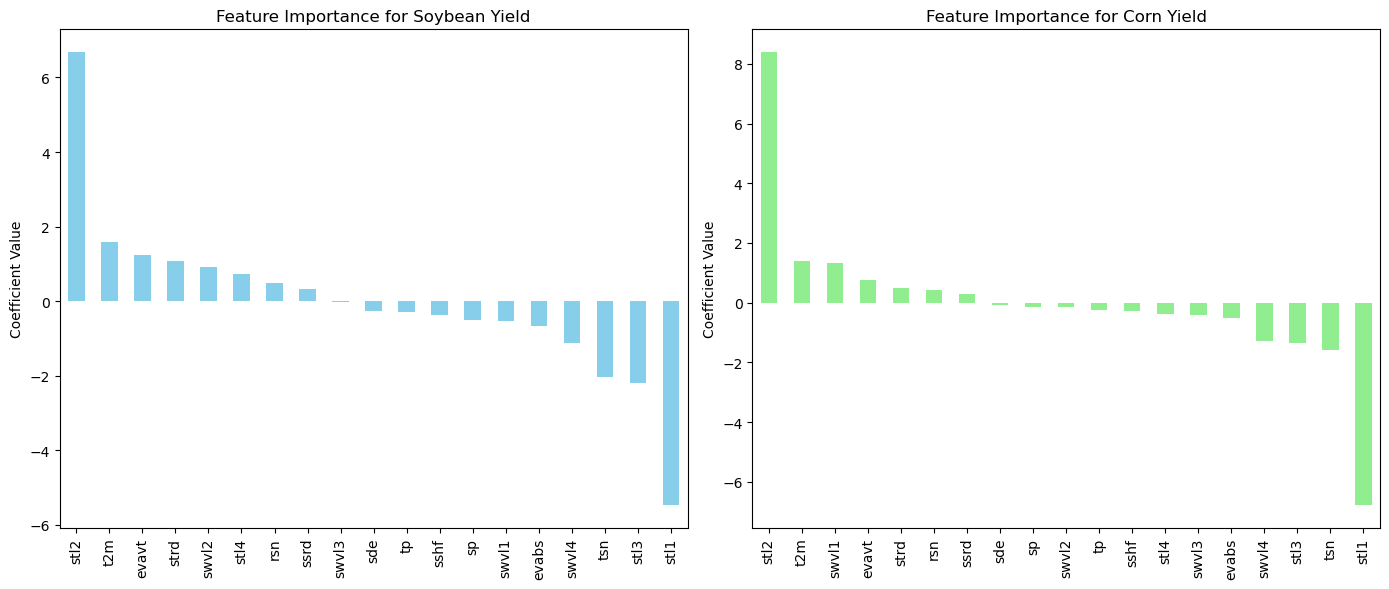

In [4]:
import matplotlib.pyplot as plt

# Feature importance based on coefficients for Soybean and Corn models
soybean_coefficients = pd.Series(soybean_model.coef_, index=X.columns).sort_values(ascending=False)
corn_coefficients = pd.Series(corn_model.coef_, index=X.columns).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
soybean_coefficients.plot(kind='bar', title='Feature Importance for Soybean Yield', color='skyblue')
plt.ylabel('Coefficient Value')

plt.subplot(1, 2, 2)
corn_coefficients.plot(kind='bar', title='Feature Importance for Corn Yield', color='lightgreen')
plt.ylabel('Coefficient Value')

plt.tight_layout()
plt.show()

Feature Importance Analysis:

Use the coefficients from the linear regression models to identify which ERA5 features have the strongest influence on the crop yields.

The bar charts above illustrate the feature importance for predicting soybean and corn yields, based on the regression model coefficients. Features with larger absolute values (positive or negative) have a stronger influence on the target variables.

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define independent (X) and dependent variables (y)
X = df_normalized.drop(columns=['Soybean Value', 'Corn Value'])
y_soybean = df_normalized['Soybean Value']
y_corn = df_normalized['Corn Value']

# Split the data into training and testing sets
X_train, X_test, y_soybean_train, y_soybean_test = train_test_split(X, y_soybean, test_size=0.2, random_state=42)
_, _, y_corn_train, y_corn_test = train_test_split(X, y_corn, test_size=0.2, random_state=42)

# Define models to test
models = {
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "DecisionTree": DecisionTreeRegressor()
}

# Define hyperparameters for grid search
param_grid = {
    "Ridge": {"alpha": [0.1, 1, 10, 100]},
    "Lasso": {"alpha": [0.01, 0.1, 1, 10]},
    "DecisionTree": {"max_depth": [3, 5, 10, None], "min_samples_split": [2, 5, 10]}
}

# Perform Grid Search for each model
best_models = {}
for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_soybean_train)
    best_models[f"{model_name}_Soybean"] = grid_search.best_estimator_
    grid_search.fit(X_train, y_corn_train)
    best_models[f"{model_name}_Corn"] = grid_search.best_estimator_

# Evaluate optimized models on the test set
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

optimized_results = {}
for model_name, model in best_models.items():
    target = y_soybean_test if "Soybean" in model_name else y_corn_test
    predictions = model.predict(X_test)
    mse, mae, r2 = evaluate_model(target, predictions)
    optimized_results[model_name] = {"MSE": mse, "MAE": mae, "R2": r2}

print(optimized_results)

{'Ridge_Soybean': {'MSE': 0.4334892526699598, 'MAE': 0.5161343340031601, 'R2': 0.573128775893958}, 'Ridge_Corn': {'MSE': 0.6531061031015608, 'MAE': 0.6377888144937559, 'R2': 0.5022555218366149}, 'Lasso_Soybean': {'MSE': 0.48099333018592694, 'MAE': 0.542258851238598, 'R2': 0.5263499374467034}, 'Lasso_Corn': {'MSE': 0.6754159379388588, 'MAE': 0.6276711493143879, 'R2': 0.48525277596382776}, 'DecisionTree_Soybean': {'MSE': 1.040427838008801, 'MAE': 0.5252371478788169, 'R2': -0.024543750668162945}, 'DecisionTree_Corn': {'MSE': 1.2730136660701235, 'MAE': 0.7423054107217074, 'R2': 0.029812277202991844}}


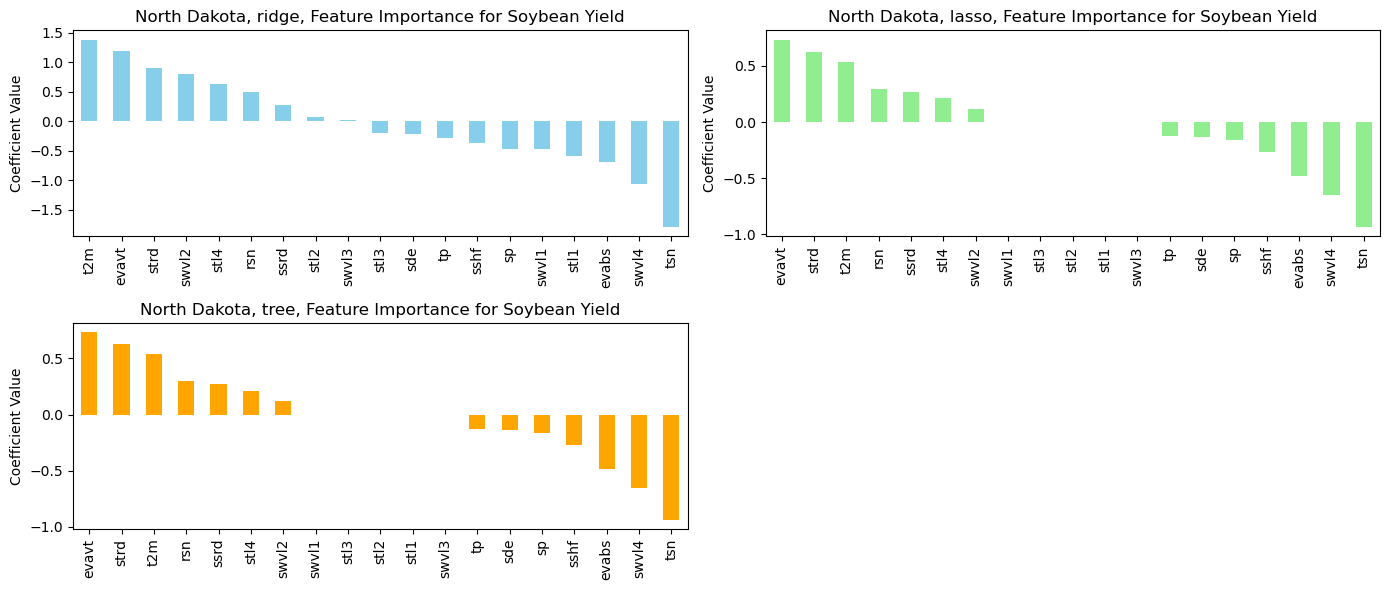

In [8]:
ridge_importance = pd.Series(best_models["Ridge_Soybean"].coef_, index=X.columns).sort_values(ascending=False)
lasso_importance = pd.Series(best_models["Lasso_Soybean"].coef_, index=X.columns).sort_values(ascending=False)
tree_importance = pd.Series(best_models["DecisionTree_Soybean"].feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(14, 6))
plt.subplot(2, 2, 1)
ridge_importance.plot(kind='bar', title='North Dakota, ridge, Feature Importance for Soybean Yield', color='skyblue')
plt.ylabel('Coefficient Value')

plt.subplot(2, 2, 2)
lasso_importance.plot(kind='bar', title='North Dakota, lasso, Feature Importance for Soybean Yield', color='lightgreen')
plt.ylabel('Coefficient Value')

plt.subplot(2, 2, 3)
lasso_importance.plot(kind='bar', title='North Dakota, tree, Feature Importance for Soybean Yield', color='orange')
plt.ylabel('Coefficient Value')

plt.tight_layout()
plt.show()

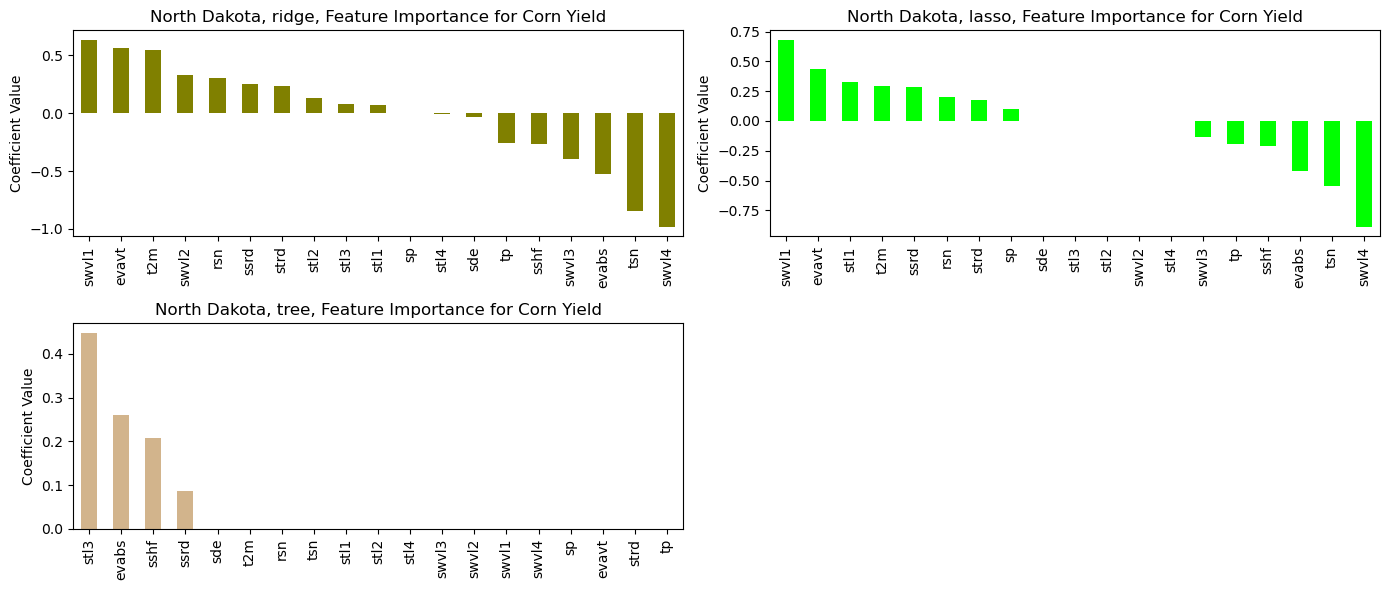

In [9]:
ridge_importance_corn = pd.Series(best_models["Ridge_Corn"].coef_, index=X.columns).sort_values(ascending=False)
lasso_importance_corn = pd.Series(best_models["Lasso_Corn"].coef_, index=X.columns).sort_values(ascending=False)
tree_importance_corn = pd.Series(best_models["DecisionTree_Corn"].feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(14, 6))
plt.subplot(2, 2, 1)
ridge_importance_corn.plot(kind='bar', title='North Dakota, ridge, Feature Importance for Corn Yield', color='olive')
plt.ylabel('Coefficient Value')

plt.subplot(2, 2, 2)
lasso_importance_corn.plot(kind='bar', title='North Dakota, lasso, Feature Importance for Corn Yield', color='lime')
plt.ylabel('Coefficient Value')

plt.subplot(2, 2, 3)
tree_importance_corn.plot(kind='bar', title='North Dakota, tree, Feature Importance for Corn Yield', color='tan')
plt.ylabel('Coefficient Value')

plt.tight_layout()
plt.show()